In [14]:
from base import *
from utils import pauli_sum, entropy, Operators
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp, AerPauliExpectation
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The Two qubit systems
$$
H_{\mathrm{I}}=H_x\sigma_x\otimes\sigma_x+H_z\sigma_z\otimes\sigma_z,
$$

In [15]:
# Constant
Hx = 2.0
Hz = 3.0

# H_0
H0_coeff = np.array([0.0, 2.5, 6.5, 7.0])
H0 = np.diag(H0_coeff)


H1 = np.array([[Hz, 0, 0, 0],
            [0, -Hz, Hx, 0],
            [0,  Hx, -Hz, 0],
            [Hx, 0, 0, + Hz]])
H0

array([[0. , 0. , 0. , 0. ],
       [0. , 2.5, 0. , 0. ],
       [0. , 0. , 6.5, 0. ],
       [0. , 0. , 0. , 7. ]])

### Classical numerical solver for the eigenvalues and the Von Neumann entropy 

$$
S(A,B)=-\mathrm{Tr}\left(\rho_{A,B}\log_2 (\rho_{A,B})\right).
$$

In [16]:
def H(lmb):
    return H0 + lmb * H1

# def partial_trace(state, i):
'''deprecated, replaced by np.einsum'''
#     state0 = np.array([1,0])
#     state1 = np.array([0,1])
#     density = np.outer(state, np.conj(state))
#     op0 = np.kron(state0, I) if i == 0 else np.kron(I, state0)
#     op1 = np.kron(state1, I) if i == 0 else np.kron(I, state1)
#     return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T



lmbs = np.arange(0, 1, 0.001)
eigs = np.zeros((4, len(lmbs)))
entropies = np.zeros((4, len(lmbs)))
vn_entropies = np.zeros((4, len(lmbs)))

for i, lmb in enumerate(lmbs):
    ham = H(lmb)
    eigvals, eigvecs = np.linalg.eig(ham)
    eigs[:,i] = sorted(eigvals)
    lmb_entropy = np.zeros(4)
    # vn_entropies[:,i] = entropy(ham, np.arange(4))[0] # returns both, doesn't matter which one you take
    vn_entropies[:,i] = entropy(ham, 0)[0]




In [17]:
plot_2D(lmbs, eigs, plot_count=4, title="Numerical Eigenvalues-2", x_title=r'$\lambda$', y_title='Energies',label=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'], filename='eigs-2-cl.pdf')
plot_2D(lmbs, vn_entropies, plot_count=4, title="Entropies", x_title=r'$\lambda$', y_title='Entropies',filename='entropies-2-cl.pdf')

### VQE

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$ H_0 = \begin{bmatrix}
    0 & 0 & 0 & 0  \\
    0 & 2.5 & 0 & 0  \\
    0 & 0 & 6.5 & 0 \\
    0 & 0 & 0 & 7 
    \end{bmatrix}
$$

Rewrite $H_0$ in terms of the computational basis $Z$ and $I$.
$$
    H_0 = a I\otimes I + b I\otimes Z + cZ\otimes I + dZ\otimes Z,
$$
Solving the above equations, we get
$$
a = 4, b = -0.75, c = -2.75, d = -0.5
$$

and using the gates we have to switch to the computational basis $Z \otimes I$ we have:

Let the swap gate be denoted by $\mathcal{S}$, and cnot gate with control on qubit 1 and target on qubit 0 be $\mathcal{CN}$.
$$
\newcommand{\swap}{\mathcal{S}} 
\newcommand{\cnot}{\mathcal{CN}(1,0)} 
$$
$$ 
H_0 = 4 I\otimes I + -0.75 (\swap Z \otimes I \swap) + -2.75 Z\otimes I + -0.5 (\cnot Z \otimes I \cnot) 
$$

$$
H_{\mathrm{I}}=H_x\sigma_x\otimes\sigma_x+H_z\sigma_z\otimes\sigma_z,
$$H
Rewrite $X$ into $I \otimes Z$
$$
H_I = H_x (I \otimes \sigma_z) (\sigma_z \otimes I) + H_z (\sigma_z \otimes I) (I \otimes \sigma_z)
$$

$$
H_I = \lambda (Hx \swap Z \otimes I \swap) + \lambda (Hz \cnot Z \otimes I \cnot)
$$

$$
\begin{aligned}
H = H_0 + H_I = &4 \: I\otimes I \\
&+ (-0.75 + \lambda Hx) \: (\swap Z \otimes I \swap) \\
&+ -2.75 \: Z \otimes I \\
&+ (-0.5 + \lambda Hz) \:(\cnot Z \otimes I \cnot) \\
\end{aligned}


In [18]:
def H(lmb): 
    return PauliSumOp.from_list([('II', 4),
                                 ('IZ', (-0.75)),
                                 ('ZI', (-2.75)),
                                 ('ZZ', (-0.5 + lmb * Hz)),
                                 ('XX', (lmb * Hx))])

H(0)


PauliSumOp(SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 4.  +0.j, -0.75+0.j, -2.75+0.j, -0.5 +0.j,  0.  +0.j]), coeff=1.0)

Set up

In [19]:
def ansatz():
    '''creates an ansatz for vqe
    inputs:
        n: int, number of qubits
    return:
        qc: QuantumCircuit object, parametrized quantum circuit with given number of qubits, with parameters 
        thetas and phis
        '''
    # TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    n=2
    qc = QuantumCircuit(n)
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')

    qc.rx(theta0,0)
    qc.ry(phi0,0)
    qc.rx(theta1,1)
    qc.ry(phi1,1)
    
    return qc

def prep_vqe(n):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2*n), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [20]:
n_points=100
n_qubits=2

lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




lmb = 0.0, energy = 2.815644868925382e-07
lmb = 0.01, energy = 0.030000090854980257
lmb = 0.02, energy = 0.06000004207937735
lmb = 0.03, energy = 0.09000011160211946
lmb = 0.04, energy = 0.12000002436391784
lmb = 0.05, energy = 0.15000001291293788
lmb = 0.06, energy = 0.1800000039887664
lmb = 0.07, energy = 0.2100000003446283
lmb = 0.08, energy = 0.24000020721127127
lmb = 0.09, energy = 0.27000000001038515
lmb = 0.1, energy = 0.3000000017761739
lmb = 0.11, energy = 0.33000000550276204
lmb = 0.12, energy = 0.3600000049287277
lmb = 0.13, energy = 0.39000000298432075
lmb = 0.14, energy = 0.4200000024205755
lmb = 0.15, energy = 0.45000028457578667
lmb = 0.16, energy = 0.48000014918568995
lmb = 0.17, energy = 0.5100001942122461
lmb = 0.18, energy = 0.5400003514231764
lmb = 0.19, energy = 0.5700006461167816
lmb = 0.2, energy = 0.6000001391637737
lmb = 0.21, energy = 0.6300002853494442
lmb = 0.22, energy = 0.6600005258980652
lmb = 0.23, energy = 0.6900001300946711
lmb = 0.24, energy = 0.72000

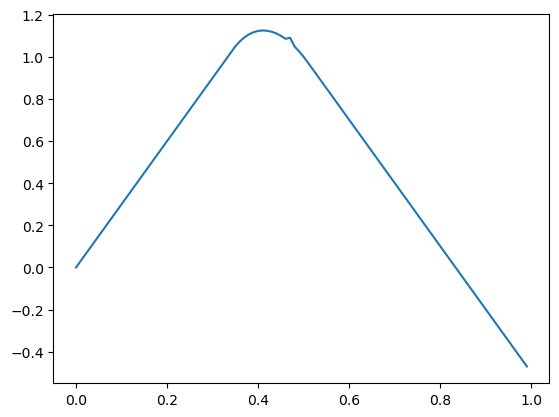

In [21]:
plt.plot(lmbs/n_points, energies)
# plot_2D(lmbs/n_points, energies, title="Ground State Energy for 2 qubits with qiskit", x_title=r'$\lambda$', y_title='Energy',
        # filename='qk-2.pdf'), 
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [22]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qc = Qubits_2()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    return qc

def my_H(lmb):
    return pauli_sum([('II', 4),
            ('IZ', (-0.75)),
            ('ZI', (-2.75)),
            ('ZZ', (-0.5 + lmb * Hz)),
            ('XX', (lmb * Hx))])

my_H(0.5)



array([[1.5, 0. , 0. , 1. ],
       [0. , 1. , 1. , 0. ],
       [0. , 1. , 5. , 0. ],
       [1. , 0. , 0. , 8.5]])

In [23]:
a = my_ansatz(np.ones(4)* np.random.uniform(low=-np.pi/2, high=np.pi/2))
a

Qubit(s) in state: 
 1.00+0.00j|00⟩ + -0.04+0.04j|01⟩ + -0.04+0.04j|10⟩ + 0.00-0.00j|11⟩ 

In [24]:
from algorithms import Vqe 

In [25]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=4)
my_vqe = Vqe(my_ansatz, init_points)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    print(lmb)
    my_ham = my_H(lmb)
    print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham)
    print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy

#TODO: why does it need to be adjusted?
# if min(my_energies) < 0:
#     my_energies += -min(my_energies)


0.0
[[0.  0.  0.  0. ]
 [0.  2.5 0.  0. ]
 [0.  0.  6.5 0. ]
 [0.  0.  0.  7. ]]
lambda: 0.0, energy: 4.521634639351838e-13
0.01
[[0.03 0.   0.   0.02]
 [0.   2.47 0.02 0.  ]
 [0.   0.02 6.47 0.  ]
 [0.02 0.   0.   7.03]]
lambda: 0.01, energy: 0.030000000000298486
0.02
[[0.06 0.   0.   0.04]
 [0.   2.44 0.04 0.  ]
 [0.   0.04 6.44 0.  ]
 [0.04 0.   0.   7.06]]
lambda: 0.02, energy: 0.060000000000210024
0.03
[[0.09 0.   0.   0.06]
 [0.   2.41 0.06 0.  ]
 [0.   0.06 6.41 0.  ]
 [0.06 0.   0.   7.09]]
lambda: 0.03, energy: 0.0900000000001509
0.04
[[0.12 0.   0.   0.08]
 [0.   2.38 0.08 0.  ]
 [0.   0.08 6.38 0.  ]
 [0.08 0.   0.   7.12]]
lambda: 0.04, energy: 0.12000000000010765
0.05
[[0.15 0.   0.   0.1 ]
 [0.   2.35 0.1  0.  ]
 [0.   0.1  6.35 0.  ]
 [0.1  0.   0.   7.15]]
lambda: 0.05, energy: 0.15000000000007585
0.06
[[0.18 0.   0.   0.12]
 [0.   2.32 0.12 0.  ]
 [0.   0.12 6.32 0.  ]
 [0.12 0.   0.   7.18]]
lambda: 0.06, energy: 0.18000000000005253
0.07
[[0.21 0.   0.   0.14]
 [0.   

/Users/bukser/mambaforge/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/bukser/mambaforge/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


lambda: 0.3, energy: 0.9000000000212817
0.31
[[0.93 0.   0.   0.62]
 [0.   1.57 0.62 0.  ]
 [0.   0.62 5.57 0.  ]
 [0.62 0.   0.   7.93]]
lambda: 0.31, energy: 0.9300000000028925
0.32
[[0.96 0.   0.   0.64]
 [0.   1.54 0.64 0.  ]
 [0.   0.64 5.54 0.  ]
 [0.64 0.   0.   7.96]]
lambda: 0.32, energy: 0.9600000000015791
0.33
[[0.99 0.   0.   0.66]
 [0.   1.51 0.66 0.  ]
 [0.   0.66 5.51 0.  ]
 [0.66 0.   0.   7.99]]
lambda: 0.33, energy: 0.9900000000010218
0.34
[[1.02 0.   0.   0.68]
 [0.   1.48 0.68 0.  ]
 [0.   0.68 5.48 0.  ]
 [0.68 0.   0.   8.02]]
lambda: 0.34, energy: 1.0200000000225473
0.35
[[1.05 0.   0.   0.7 ]
 [0.   1.45 0.7  0.  ]
 [0.   0.7  5.45 0.  ]
 [0.7  0.   0.   8.05]]
lambda: 0.35, energy: 1.0492592906144442
0.36
[[1.08 0.   0.   0.72]
 [0.   1.42 0.72 0.  ]
 [0.   0.72 5.42 0.  ]
 [0.72 0.   0.   8.08]]
lambda: 0.36, energy: 1.0735339555636745
0.37
[[1.11 0.   0.   0.74]
 [0.   1.39 0.74 0.  ]
 [0.   0.74 5.39 0.  ]
 [0.74 0.   0.   8.11]]
lambda: 0.37, energy: 1.0925

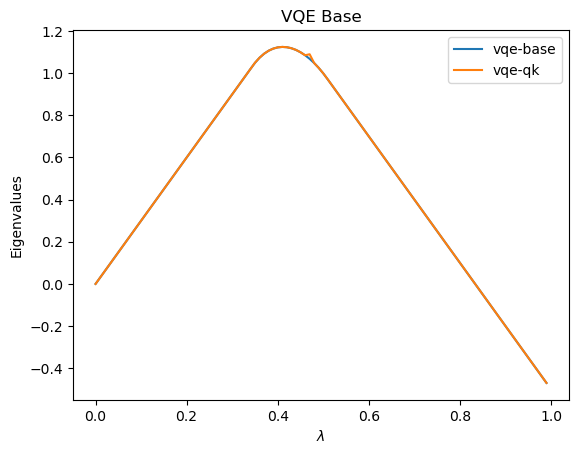

In [26]:

plt.plot(lmbs/n_points, my_energies, label='vqe-base')
plt.plot(lmbs/n_points, energies, label='vqe-qk')
# plt.plot(2/3* np.ones(n_points), np.linspace(min(my_energies), 1.01*max(my_energies), n_points), label=r'$\lambda=2/3$')

plt.xlabel(r'$\lambda$')
plt.ylabel('Eigenvalues')
plt.title('VQE Base')
plt.legend()
plt.show()